# Explore the Dataset

Root folders for the dataset. One full dataset and one reduced dataset

In [ ]:
gemstones_all_folder = str("/content/drive/MyDrive/Colab/gemstones")
gemstones_less_folder = str("/content/drive/MyDrive/Colab/gemstones_less")
gemstones_tests_folder = str("/content/drive/MyDrive/Colab/gemstones_tests")

gemstones_folder = gemstones_all_folder

Get a copy of the directory path to every gemstone image

In [ ]:
import os

In [ ]:
def get_gemstones():
    Images, Labels = [], []
    for root, folders, images in os.walk(gemstones_folder):
        for image in images:
            if image.endswith('.jpg'):
                Labels.append(os.path.join(root, image))
            try:
                img = cv2.imread(os.path.join(root, image))              # read the image (OpenCV)
                img = cv2.resize(img,(int(img_w*1.5), int(img_h*1.5)))       # resize the image (images are different sizes)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # converts an image from BGR color space to RGB
                Images.append(img)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    
    return (Images, Labels)

(Images, Labels) = get_gemstones()

Plot some random gemstones to view

In [ ]:
import random
from matplotlib import pyplot as plot
from matplotlib import image as plot_image

In [ ]:
def plot_random_gemstones(rows=5, cols=6, img_size=2.5):
    random_gemstones = plot.figure(figsize=(img_size*cols, img_size*rows))
    images = []
    for i in range(1, rows*cols+1):
        images.append(plot_image.imread(random.choice(Labels)))
    for i in range(1, rows*cols+1):
        image = images[i-1]
        ax = random_gemstones.add_subplot(rows, cols, i)
        ax.axis('off')
        plot.imshow(image)
    plot.show()

Run this cell to see a new random subset of the gemstones

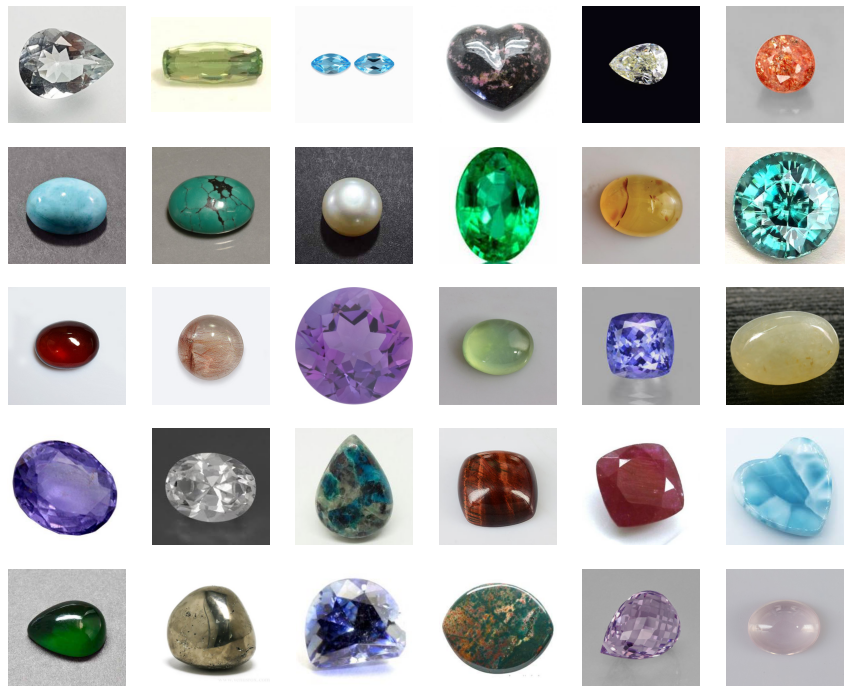

In [ ]:
plot_random_gemstones()

###### WIP, not relevant to final submission

In [ ]:
import cv2
from random import randint

In [ ]:
img_w = 256
img_h = 256

read in images and labels

try and crop the images to fit the gemstone

Text(0.5, 1.0, 'Cropped Images')

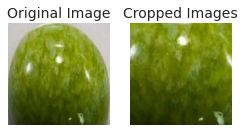

In [ ]:
def edge_and_cut(img, path):
    try:
        edges = cv2.Canny(img, img_w, img_h)            
        
        if(np.count_nonzero(edges)>edges.size/10000):           
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)
            
            new_img = img[y1:y2, x1:x2]           # crop the region
            new_img = cv2.resize(new_img,(img_w, img_h))  # Convert back
        else:
            new_img = cv2.resize(img,(img_w, img_h))
    
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    cv2.imwrite(path, new_img)
    return new_img

i = 2

new_img = edge_and_cut(Images[i], Labels[i])
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(4, 3))
ax[0].axis('off')
ax[0].imshow(Images[i], cmap='gray')
ax[0].set_title('Original Image', fontsize=14)
ax[1].axis('off')
ax[1].imshow(new_img, cmap='gray')
ax[1].set_title('Cropped Images', fontsize=14)

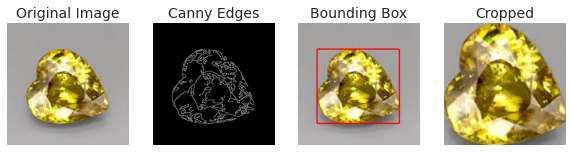

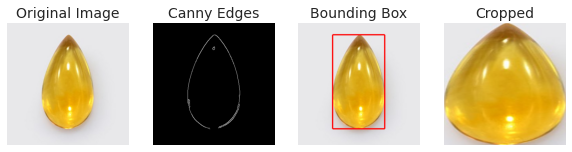

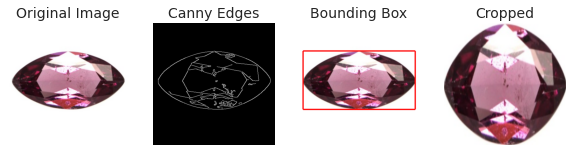

In [ ]:
def show_cropped(img):
    emb_img = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    edges = cv2.Canny(blurred, 15, 255)
    
    if(np.count_nonzero(edges)>edges.size/10000):
        pts = np.argwhere(edges>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)

        new_img = img[y1:y2, x1:x2]  

        edge_size = 2 #replace it with bigger size for larger images            

        emb_img[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
        emb_img[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]

        new_img = cv2.resize(new_img,(img_w, img_h))  # Convert to primary size  
        
    else:
        new_img = cv2.resize(img,(img_w, img_h))
    
    fig, ax = plot.subplots(nrows=1, ncols=4, figsize=(10, 10))
    ax[0].axis('off')
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)
    ax[1].axis('off')
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=14)
    ax[2].axis('off')
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=14)       
    ax[3].axis('off')
    ax[3].imshow(new_img, cmap='gray')
    ax[3].set_title('Cropped', fontsize=14)

for x in range(0,3):
    show_cropped(Images[randint(0,len(Images))])

# Data Preparation

Set up the ImageDataGenerators to normalize the rgb values, do some slight translation, and split the dataset into validation and training data

In [ ]:
import random
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen_kwargs_augment = dict(
    rotation_range = 2,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 1,
    # fill_mode = "nearest",
    horizontal_flip = True,
    vertical_flip = True,
    rescale = 1/255,
    validation_split = 0.10,
)

datagen_kwargs_default = dict(rescale = 1/255)

target_resolution = (256, 256)
random_seed = random.randrange(0, 10000, 1)
# random_seed = 1369

training_datagen = ImageDataGenerator(**datagen_kwargs_augment)
training_generator = training_datagen.flow_from_directory(
    gemstones_folder,
    target_size = target_resolution,
    color_mode = "rgb",
    shuffle = random_seed,
    seed = 1369,
    subset = "training",
    batch_size = 12
)

validation_datagen = ImageDataGenerator(**datagen_kwargs_augment)
validation_generator = validation_datagen.flow_from_directory(
    gemstones_folder, 
    target_size = target_resolution,
    color_mode = "rgb",
    shuffle = True,
    seed = random_seed,
    subset = "validation",
    batch_size = 12
)

test_datagen = ImageDataGenerator(**datagen_kwargs_default)
test_generator = training_datagen.flow_from_directory(
    gemstones_folder, 
    target_size = target_resolution,
    color_mode = "rgb",
    shuffle = False,
    subset = "validation",
    batch_size = 12,
)

full_datagen = ImageDataGenerator(**datagen_kwargs_default)
full_generator = training_datagen.flow_from_directory(
    gemstones_folder, 
    target_size = target_resolution,
    color_mode = "rgb",
    shuffle = False,
    batch_size = 12,
)


Found 2614 images belonging to 77 classes.
Found 253 images belonging to 77 classes.
Found 253 images belonging to 77 classes.
Found 2867 images belonging to 77 classes.


# Model Architecture

In [ ]:
from keras.models import Model
from keras.layers import *
from keras.regularizers import *

Colvolutional layers

In [ ]:
image_input = Input(shape = (256, 256, 3))

# Block 1
layer = Conv2D(32, 2, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001), padding='same')(image_input)
layer = AveragePooling2D(2)(layer)
layer = Conv2D(32, 2, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001), padding='same')(layer)
layer = AveragePooling2D(2)(layer)
layer = Conv2D(32, 2, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D(2)(layer)
layer = Dropout(0.33)(layer)

# Block 2
layer = Conv2D(64, 2, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001), padding='same')(layer)
layer = AveragePooling2D(2)(layer)
layer = Conv2D(64, 2, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D(2)(layer)
layer = Dropout(0.33)(layer)

# Block 3
layer = Conv2D(128, 2, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001), padding='same')(layer)
layer = AveragePooling2D(2)(layer)
layer = Conv2D(128, 2, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D(2)(layer)
layer = Dropout(0.5)(layer)

Flattened & Dense layers

In [ ]:
layer = Flatten()(layer)
layer = Dense(128, activation='softmax', kernel_regularizer=l2(0.0001))(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.5)(layer)
output = Dense(full_generator.num_classes, activation='softmax')(layer)

model = Model(image_input, output)

Model Summary

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 256, 256, 32)      416       
_________________________________________________________________
average_pooling2d_15 (Averag (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 128, 32)      4128      
_________________________________________________________________
average_pooling2d_16 (Averag (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 32)        4128      
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 64, 32)        128 

# Model Training

Training Parameters

In [ ]:
import numpy as np
from keras.optimizers import Adam
from keras.metrics import TopKCategoricalAccuracy

In [ ]:
adam = Adam(learning_rate=0.0002)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=["mse", "accuracy", TopKCategoricalAccuracy(3, "top-3 accuracy")])

In [ ]:
def get_callbacks():
    return
    [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_mse', mode=auto, patience=10, restore_best_weights=True),
    ]

In [ ]:
train_steps = np.ceil(training_generator.samples / training_generator.batch_size)
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)

Training the model

In [ ]:
# history = model.fit(
#     training_generator,
#     epochs = 250,
#     steps_per_epoch = train_steps,
#     validation_data = validation_generator,
#     validation_steps = val_steps,
#     callbacks = get_callbacks(),
#     verbose=1)

Save Model

In [ ]:
# model.save("/content/drive/MyDrive/Colab/gemstone_model_250")

# Evaluation

Load a Previous Model

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model("/content/drive/MyDrive/Colab/gemstone_model_250")

Evaluate the Test Dataset

In [ ]:
import numpy as np

In [ ]:
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)

In [ ]:
evaluation = model.evaluate(test_generator, steps=test_steps)
# print(evaluation)

22/22 [==============================] - 111s 4s/step - loss: 1.5388 - mse: 0.0068 - accuracy: 0.6245 - top-3 accuracy: 0.8656


In [ ]:
predictions = model.predict(test_generator, test_steps)
predictions = np.argmax(predictions, axis=1)
print(test_generator.classes)
print(predictions)

[ 0  0  0  0  1  1  1  2  2  2  3  3  3  4  4  4  5  5  5  6  6  6  6  7
  7  7  7  7  8  8  8  9  9  9 10 10 10 10 11 11 11 12 12 12 12 13 13 13
 14 14 14 15 15 15 16 16 16 17 17 17 18 18 18 18 19 19 19 20 20 20 20 21
 21 21 22 22 22 23 23 23 24 24 24 24 25 25 25 26 26 26 26 27 27 27 28 28
 28 29 29 29 30 30 30 31 31 31 32 32 32 32 33 33 33 34 34 34 35 35 35 35
 36 36 36 37 37 37 38 38 38 39 39 39 39 40 40 40 41 41 41 42 42 42 43 43
 43 44 44 44 44 45 45 45 46 46 46 46 47 47 47 47 48 48 48 48 49 49 49 50
 50 50 51 51 51 52 52 52 52 53 53 53 54 54 54 55 55 55 55 56 56 56 57 57
 57 58 58 58 59 59 59 60 60 60 61 61 61 62 62 62 63 63 63 64 64 64 65 65
 65 66 66 66 67 67 67 68 68 68 68 69 69 69 69 70 70 70 71 71 71 71 72 72
 72 73 73 73 74 74 74 75 75 75 76 76 76]
[ 6  0  0 60  1  1 73 49 52 13  3 60 60  4  4  4  5 61  5  6  6  6  6  7
  7 31  7  7  8  8  8 58 63  9 57 10 10 10 11 11 11 16 68 12 12 21 13 13
 52 14 14  8 67  8 16 16 16 17 17 72  0 73 18 18 19 19 19  8 64 20 20 13
 21 54 22 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
matrix = confusion_matrix(test_generator.classes, predictions)

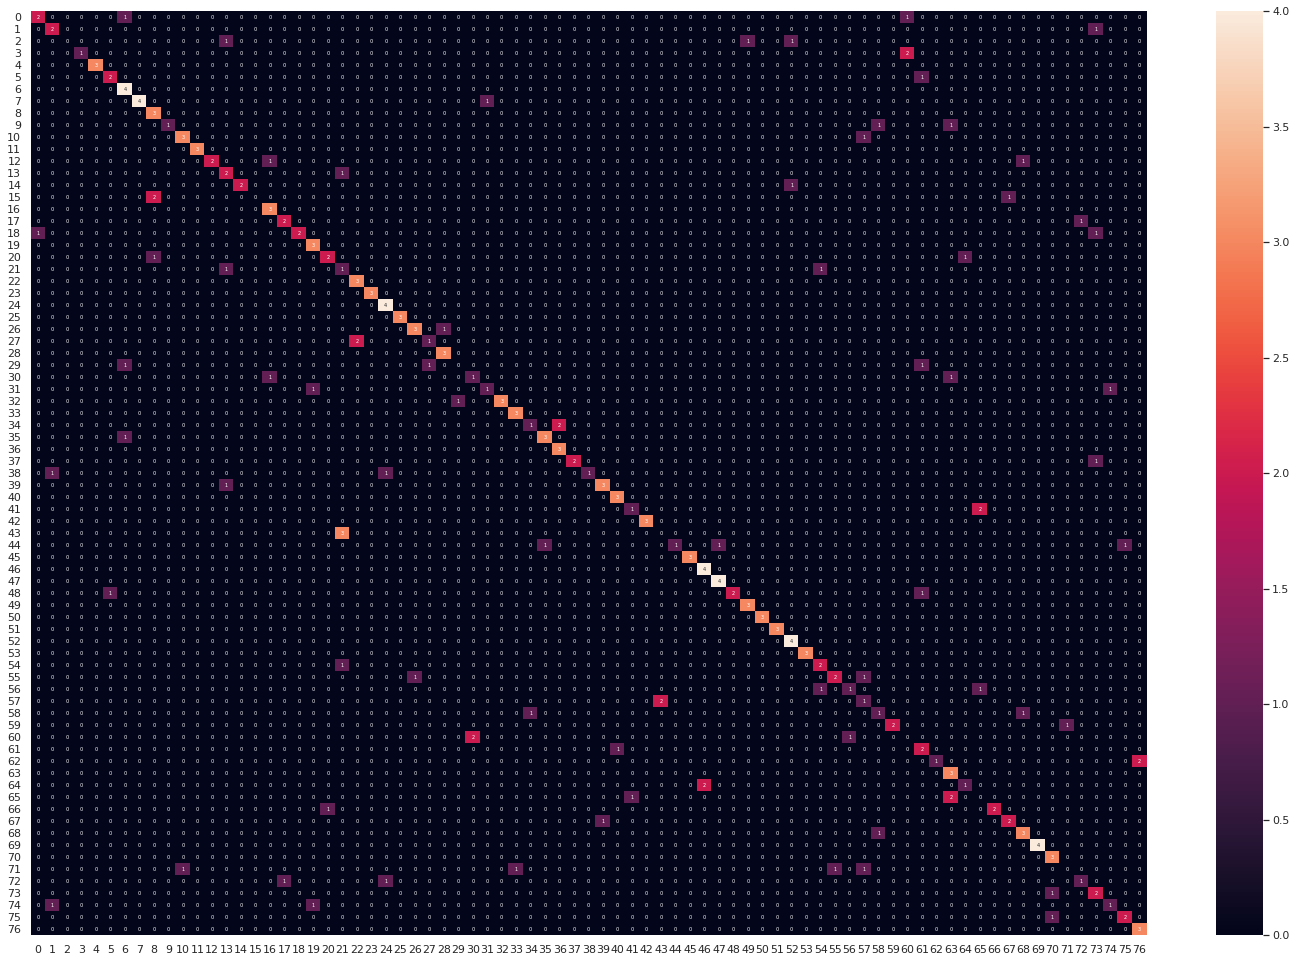

In [ ]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(matrix)
plot.figure(figsize=(25,17))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 5}) # font size

plot.show()

In [ ]:
report = classification_report(test_generator.classes, predictions, target_names=test_generator.class_indices)
print(report)

                   precision    recall  f1-score   support

      Alexandrite       0.67      0.50      0.57         4
        Amazonite       0.50      0.67      0.57         3
            Amber       0.00      0.00      0.00         3
         Amethyst       1.00      0.33      0.50         3
         Ametrine       1.00      1.00      1.00         3
       Andalusite       0.67      0.67      0.67         3
       Aquamarine       0.57      1.00      0.73         4
 Aventurine Green       1.00      0.80      0.89         5
Aventurine Yellow       0.50      1.00      0.67         3
        Benitoite       1.00      0.33      0.50         3
          Bixbite       0.75      0.75      0.75         4
       Bloodstone       1.00      1.00      1.00         3
  Blue Lace Agate       1.00      0.50      0.67         4
        Carnelian       0.40      0.67      0.50         3
         Cats Eye       1.00      0.67      0.80         3
       Chalcedony       0.00      0.00      0.00       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluate the Full Dataset

In [ ]:
full_steps = np.ceil(full_generator.samples / full_generator.batch_size)

In [ ]:
evaluation = model.evaluate(full_generator, steps=full_steps)
# print(evaluation)

239/239 [==============================] - 43s 180ms/step - loss: 0.5750 - mse: 0.0029 - accuracy: 0.8535 - top-3 accuracy: 0.9777


In [ ]:
predictions = model.predict(full_generator, full_steps)
predictions = np.argmax(predictions, axis=1)
print(full_generator.classes)
print(predictions)

[ 0  0  0 ... 76 76 76]
[ 6  0  0 ... 76 76 76]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
matrix = confusion_matrix(full_generator.classes, predictions)

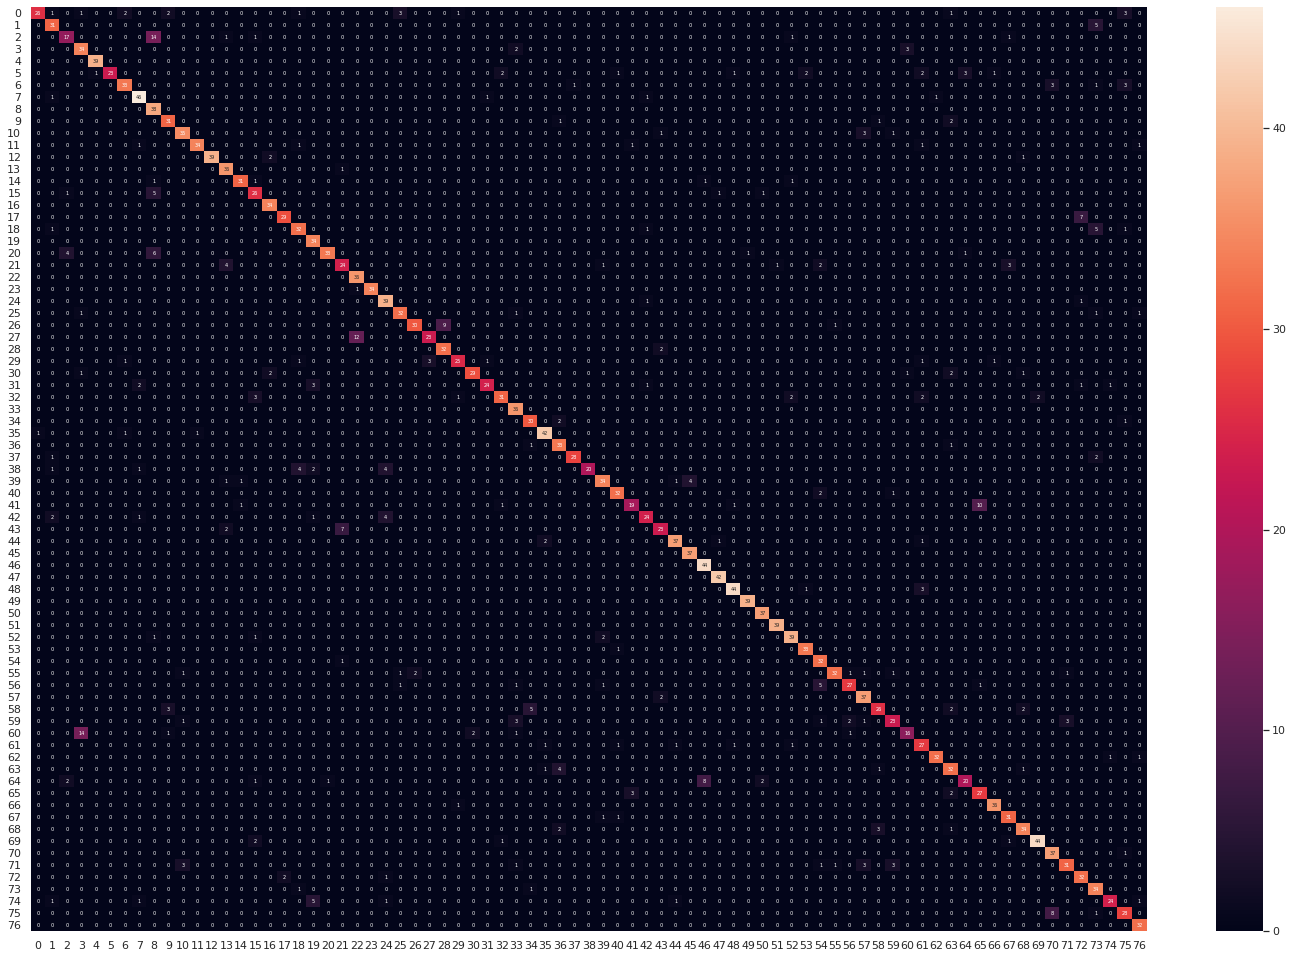

In [ ]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(matrix)
plot.figure(figsize=(25,17))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 5}) # font size

plot.show()

In [ ]:
report = classification_report(full_generator.classes, predictions, target_names=full_generator.class_indices)
print(report)

                   precision    recall  f1-score   support

      Alexandrite       0.96      0.63      0.76        41
        Amazonite       0.79      0.86      0.83        36
            Amber       0.71      0.49      0.58        35
         Amethyst       0.67      0.87      0.76        39
         Ametrine       0.97      1.00      0.99        39
       Andalusite       1.00      0.64      0.78        36
       Aquamarine       0.89      0.80      0.85        41
 Aventurine Green       0.88      0.92      0.90        50
Aventurine Yellow       0.58      1.00      0.74        38
        Benitoite       0.84      0.89      0.86        35
          Bixbite       0.88      0.88      0.88        40
       Bloodstone       0.97      0.87      0.92        39
  Blue Lace Agate       1.00      0.93      0.96        42
        Carnelian       0.82      0.97      0.89        37
         Cats Eye       0.94      0.89      0.91        35
       Chalcedony       0.74      0.76      0.75       

Diagnotic Summary

In [ ]:
def summarize_diagnostics(history):

    summary, (ax1, ax2, ax3) = plot.subplots(3, figsize=(12,18))
    
    ax1.set_title('Top 3 Classification Accuracy')
    ax1.set(ylim=(0.0, 1.05))
    ax1.plot(history.history['top-3 accuracy'], color='blue', label='train')
    ax1.plot(history.history['val_top-3 accuracy'], color='orange', label='test')

    ax2.set_title('Classification Accuracy')
    ax2.set(ylim=(0.0, 1.05))
    ax2.plot(history.history['accuracy'], color='blue', label='train')
    ax2.plot(history.history['val_accuracy'], color='orange', label='test')

    ax3.set_title("Mean Squared Error")
    ax3.plot(history.history['mse'], color='blue', label='train')
    ax3.plot(history.history['val_mse'], color='orange', label='test')

    plot.show()
    plot.close()

Show Graphs

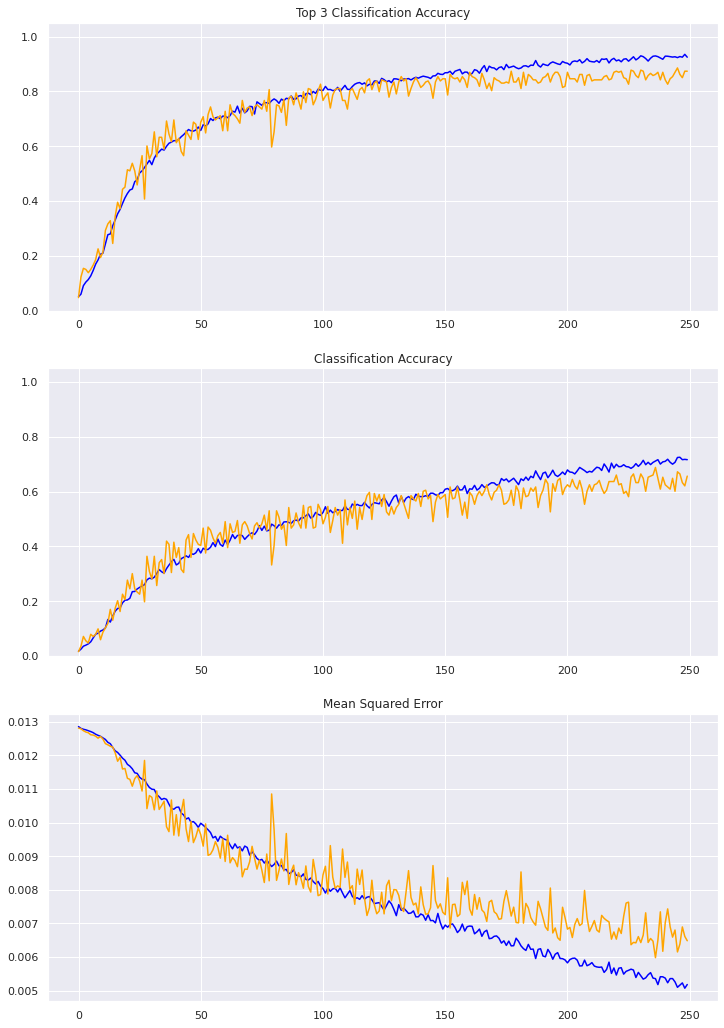

In [ ]:
summarize_diagnostics(history)